<a href="https://colab.research.google.com/github/mitesh98/Amazon-Fine-Food-Review/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review
Text - text of the review

Objective: Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import tqdm

In [0]:
import sqlite3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

# Readind Data

In [0]:
con=sqlite3.connect("database.sqlite")

In [6]:
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [8]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis
# 2.1 Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
sorted_data.shape

(525814, 10)

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

**Observation**:- bold text It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions



In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [12]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 3. Preprocessing
In the Preprocessing phase we do the following in the order below:-

1.Begin by removing the linksand html tags

2.Expand English language contractions and Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [13]:
#print(link)
for i in range(0,1000):
  links=re.findall(r'http\S+',final['Text'].values[i])
  for link in links:
    print(link)

http://www.amazon.com/gp/product/B0002DGRSY">Pro-Treat
http://www.amazon.com/gp/product/B0019O5Z0Q">Charlee
http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br
http://www.amazon.com/gp/product/B0088EDMMS">Hocus
http://www.amazon.com/gp/product/B001AGXEAG">Beetlejuice
http://www.amazon.com/gp/product/B001AGXEAG">here</a>.
http://www.amazon.com/gp/product/B001AGXEA6">here</a>.
http://www.amazon.com/gp/product/0790700506">Gremlins</a><br
http://www.amazon.com/gp/product/6301871952">Gremlins
http://www.amazon.com/gp/product/6303347657">Mask</a><br
http://www.amazon.com/gp/product/6304826141">Rocketman</a><br
http://www.amazon.com/gp/product/B001B504LI">The
http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice
http://www.amazon.com/gp/product/B00004RAMX">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME
http://www.amazon.com/gp/product/B0051GCTAW">Fiprogua

In [0]:
for i in range(0,364171):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

In [0]:
#Remove HTML tags
from bs4 import BeautifulSoup
for i in range(1,364171):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

In [0]:
#Expanding English language contractions
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [0]:
for i in range(0,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i]=decontracted(final['Text'].values[i])
  #print(final['Text'].values[i])

In [0]:
#remove words with numbers python
for i in range(1,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i] = re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()
  #print(final['Text'].values[i])

In [0]:
#remove spacial character:
for i in range(1,364171):
  final['Text'].values[i]= re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
#Remove punctution
for i in range(1,364171):
  final['Text'].values[i]= re.sub(r'[!|#|$\%|&|*|?|,|.|\'|/|"|)|(]',r'', final['Text'].values[i])

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#tqdm
#Instantly make your loops show a smart progress meter
# just wrap any iterable with tqdm(iterable), and you’re done!
from tqdm import tqdm
preprocessed_reviews = []
for i in tqdm(range(0,364171)):
  sentence=""
  #print(final['Text'].values[i])
  for word in final['Text'].values[i].split():
    #print(word)
    word =word.lower()
    if word not in stopwords:
      sentence+=" "+word
  #print(sentence)
  preprocessed_reviews.append(sentence.strip())

100%|██████████| 364171/364171 [00:16<00:00, 22657.46it/s]


In [23]:
preprocessed_reviews[364170]

'purchased send son away college delivered right dorm room fast shipping loved much called thank sadly hardly ever calls anymore want kids call home good snack get midterms send'

In [24]:
final['Cleaned_text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud. recite...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",I grew up reading these Sendak books and watch...,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud it h...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [0]:
#Randomly sample Data 100k points
random_sample_data = final.sample(n=100000) 

In [0]:
#Randomly sample Data 20k points
random_sample_data_rbf = final.sample(n=20000) 

In [0]:
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [0]:
final_sorted_time_rbf=random_sample_data_rbf.sort_values('Time',ascending=True,axis=0)

**Time dependent Splitting**

In [0]:
y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [0]:
y_Train_rbf=final_sorted_time_rbf['Score'][0:14000]
y_train_rbf=final_sorted_time_rbf['Score'][0:9800]
y_cv_rbf=final_sorted_time_rbf['Score'][9800:14000]
y_test_rbf=final_sorted_time_rbf['Score'][14000:20000]

In [31]:
y_train.value_counts()

1    42075
0     6925
Name: Score, dtype: int64

In [32]:
y_train_rbf.value_counts()

1    8461
0    1339
Name: Score, dtype: int64

In [33]:
y_Train.value_counts()

1    59480
0    10520
Name: Score, dtype: int64

In [34]:
y_Train_rbf.value_counts()

1    11952
0     2048
Name: Score, dtype: int64

In [0]:
Train_data=final_sorted_time['Cleaned_text'][0:70000]
train_data=final_sorted_time['Cleaned_text'][0:49000]
cv_data=final_sorted_time['Cleaned_text'][49000:70000]
test_data=final_sorted_time['Cleaned_text'][70000:100000]

In [0]:
Train_data_rbf=final_sorted_time_rbf['Cleaned_text'][0:14000]
train_data_rbf=final_sorted_time_rbf['Cleaned_text'][0:9800]
cv_data_rbf=final_sorted_time_rbf['Cleaned_text'][9800:14000]
test_data_rbf=final_sorted_time_rbf['Cleaned_text'][14000:20000]

# 4. Featurization

# 4.1Bag of Words

In [0]:
count_vector=CountVectorizer()
count_vector.fit(train_data)
train_bows=count_vector.transform(train_data)
cv_bows=count_vector.transform(cv_data)
Train_bows=count_vector.transform(Train_data)
test_bows=count_vector.transform(test_data)

In [0]:
count_vector_rbf=CountVectorizer(min_df = 10, max_features = 500)
count_vector_rbf.fit(train_data_rbf)
train_bows_rbf=count_vector_rbf.transform(train_data_rbf)
cv_bows_rbf=count_vector_rbf.transform(cv_data_rbf)
Train_bows_rbf=count_vector.transform(Train_data_rbf)
test_bows_rbf=count_vector.transform(test_data_rbf)

# 4.2 TFIDF

In [0]:
tfidf_vector=TfidfVectorizer()
tfidf_vector.fit(train_data)
train_tfidf=tfidf_vector.transform(train_data)
cv_tfidf=tfidf_vector.transform(cv_data)
Train_tfidf=tfidf_vector.transform(Train_data)
test_tfidf=tfidf_vector.transform(test_data)

In [0]:
tfidf_vector_rbf=TfidfVectorizer()
tfidf_vector_rbf.fit(train_data_rbf)
train_tfidf_rbf=tfidf_vector_rbf.transform(train_data_rbf)
cv_tfidf_rbf=tfidf_vector_rbf.transform(cv_data_rbf)
Train_tfidf_rbf=tfidf_vector_rbf.transform(Train_data_rbf)
test_tfidf_rbf=tfidf_vector_rbf.transform(test_data_rbf)

# 4.3 Word2Vec

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence=[]
for sent in train_data.values:
  list_of_sentence.append(sent.split())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [56]:
# Average W2V with training Data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(sent_vectors)
print(len(sent_vectors[0]))

49000
50


In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_cv=[]
for sent in cv_data.values:
  list_of_sentence_cv.append(sent.split())

In [0]:
w2v_model_cv=gensim.models.Word2Vec(list_of_sentence_cv,min_count=5,size=50,workers=4)

In [0]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)

In [60]:
# Average W2V with cv Data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
#print(sent_vectors)
print(len(sent_vectors_cv[0]))

21000
50


In [0]:
#Train own W2V with Test data
i=0
list_of_sentence_test=[]
for sent in test_data.values:
  list_of_sentence_test.append(sent.split())

In [0]:
w2v_model_test=gensim.models.Word2Vec(list_of_sentence_test,min_count=5,size=50,workers=4)

In [0]:
w2v_words_test = list(w2v_model_test.wv.vocab)

In [64]:
# Average W2V with test Data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
#print(sent_vectors)
print(len(sent_vectors_test[0]))

30000
50


**Word2Vec For RBF**

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence_rbf=[]
for sent in train_data_rbf.values:
  list_of_sentence_rbf.append(sent.split())

In [0]:
w2v_model_rbf=gensim.models.Word2Vec(list_of_sentence_rbf,min_count=5,size=50,workers=4)

In [0]:
w2v_words_rbf = list(w2v_model_rbf.wv.vocab)

In [69]:
# Average W2V with training Data
sent_vectors_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_rbf: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf:
            vec = w2v_model_rbf.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_rbf.append(sent_vec)
print(len(sent_vectors_rbf))
#print(sent_vectors)
print(len(sent_vectors_rbf[0]))

9800
50


In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_rbf_cv=[]
for sent in cv_data_rbf.values:
  list_of_sentence_rbf_cv.append(sent.split())

In [0]:
w2v_model_rbf_cv=gensim.models.Word2Vec(list_of_sentence_rbf_cv,min_count=5,size=50,workers=4)

In [0]:
w2v_words_rbf_cv = list(w2v_model_rbf_cv.wv.vocab)

In [73]:
# Average W2V with cv Data
sent_vectors_rbf_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_rbf_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf_cv:
            vec = w2v_model_rbf_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_rbf_cv.append(sent_vec)
print(len(sent_vectors_rbf_cv))
#print(sent_vectors)
print(len(sent_vectors_rbf_cv[0]))

4200
50


In [0]:
#Train own W2V with Test data
i=0
list_of_sentence_rbf_test=[]
for sent in test_data_rbf.values:
  list_of_sentence_rbf_test.append(sent.split())

In [0]:
w2v_model_rbf_test=gensim.models.Word2Vec(list_of_sentence_rbf_test,min_count=5,size=50,workers=4)

In [0]:
w2v_words_rbf_test = list(w2v_model_rbf_test.wv.vocab)

In [77]:
# Average W2V with test Data
sent_vectors_rbf_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_rbf_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf_test:
            vec = w2v_model_rbf_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_rbf_test.append(sent_vec)
print(len(sent_vectors_rbf_test))
#print(sent_vectors)
print(len(sent_vectors_rbf_test[0]))

6000
50


# TF-IDF Word2Vec

In [0]:
#TF-IDF Avg W2V for train Data
model_train = TfidfVectorizer()
tf_idf_matrix_train = model_train.fit_transform(train_data)
dictionary = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))

In [0]:
tfidf_feat_train = model_train.get_feature_names() 

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(cv_data)
dictionary = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [0]:
tfidf_feat_cv = model_cv.get_feature_names() 

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_cv.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_cv.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for test Data
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(test_data)
dictionary = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [0]:
tfidf_feat_test = model_test.get_feature_names() 

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_test.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_test.append(sent_vec)
  row += 1

**TFIDF weighted W2V for RBF SVM**

In [0]:
#TF-IDF Avg W2V for train Data
model_rbf_train = TfidfVectorizer(min_df = 10, max_features = 500)
tf_idf_matrix_rbf_train = model_rbf_train.fit_transform(train_data_rbf)
dictionary_rbf = dict(zip(model_rbf_train.get_feature_names(), list(model_rbf_train.idf_)))

In [0]:
tfidf_feat_rbf_train = model_rbf_train.get_feature_names() 

tfidf_sent_vectors_rbf_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_rbf: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model_rbf.wv[word]
      tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_rbf_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_rbf_cv = TfidfVectorizer(min_df = 10, max_features = 500)
tf_idf_matrix_rbf_cv = model_rbf_cv.fit_transform(cv_data_rbf)
dictionary_rbf = dict(zip(model_rbf_cv.get_feature_names(), list(model_rbf_cv.idf_)))

In [0]:
tfidf_feat_rbf_cv = model_rbf_cv.get_feature_names() 

tfidf_sent_vectors_rbf_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_rbf_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_rbf_cv.wv[word]
      tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_rbf_cv.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for _rbf test Data
model_rbf_test = TfidfVectorizer(min_df = 10, max_features = 500)
tf_idf_matrix_rbf_test = model_rbf_test.fit_transform(test_data_rbf)
dictionary_rbf = dict(zip(model_rbf_test.get_feature_names(), list(model_rbf_test.idf_)))

In [0]:
tfidf_feat_rbf_test = model_rbf_test.get_feature_names() 

tfidf_sent_vectors_rbf_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_rbf_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_rbf_test.wv[word]
      tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_rbf_test.append(sent_vec)
  row += 1

#  5. SVM

# 5.1 Linear SVM

**5.1.1 Applying Linear SVM on BOW, SET 1**

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve,auc
import math

**Simple Cross Validation  Penalty = 'l2'**

In [0]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score


In [95]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  clf.fit(train_bows,y_train)
  
  #For Train Curve
  calibrator=CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
  calibrator.fit(train_bows,y_train)
  y_predict_training=calibrator.predict_proba(train_bows)
  auc=roc_auc_score(y_train,y_predict_training[:,1])
  if(not np.isnan(auc)):
    Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(auc)
    print("T-Alpha= ",alpha," ",auc)
  
  # For CV Curve
  y_predict_cv=calibrator.predict_proba(cv_bows)
  auc=roc_auc_score(y_cv,y_predict_cv[:,1])
  if(not np.isnan(auc)):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(auc)
    print("Alpha= ",alpha," ",auc)
  
  alpha*=10

T-Alpha=  0.0001   0.9702363005720831
Alpha=  0.0001   0.9243277014622195
T-Alpha=  0.001   0.9629687883292469
Alpha=  0.001   0.9377307769297185
T-Alpha=  0.01   0.9297419744267906
Alpha=  0.01   0.926567509935717
T-Alpha=  0.1   0.7549217998631461
Alpha=  0.1   0.7755325931871766
T-Alpha=  1.0   0.49185943615385114
Alpha=  1.0   0.47628533037882187
T-Alpha=  10.0   0.5621101445544852
Alpha=  10.0   0.5534353907702413
T-Alpha=  100.0   0.5650546835953504
Alpha=  100.0   0.5566488935165226
T-Alpha=  1000.0   0.5650545686210158
Alpha=  1000.0   0.5566485738795024
T-Alpha=  10000.0   0.5650558522150793
Alpha=  10000.0   0.5566498923822107


In [96]:
print(len(Alpha))
print(len(AUC_score_training))

9
9


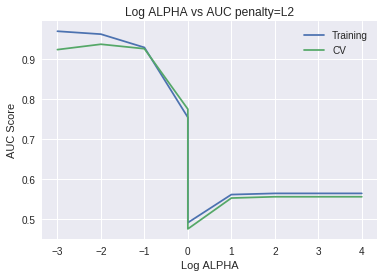

In [97]:
plt.plot(Alpha,AUC_score_training,label='Training')
plt.plot(Alpha,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**Simple Cross Validation Penalty='l1'**

In [98]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l1',alpha=alpha)
  clf.fit(train_bows,y_train)
  
  #For Train Curve
  calibrator=CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
  calibrator.fit(train_bows,y_train)
  y_predict_training=calibrator.predict_proba(train_bows)
  auc=roc_auc_score(y_train,y_predict_training[:,1])
  if(not np.isnan(auc)):
    Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(auc)
    print("T-Alpha= ",alpha," ",auc)
  
  # For CV Curve
  y_predict_cv=calibrator.predict_proba(cv_bows)
  auc=roc_auc_score(y_cv,y_predict_cv[:,1])
  if(not np.isnan(auc)):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(auc)
    print("Alpha= ",alpha," ",auc)
  
  alpha*=10

T-Alpha=  0.0001   0.9356517719132287
Alpha=  0.0001   0.9107116198844593
T-Alpha=  0.001   0.8768526479490165
Alpha=  0.001   0.8833029132117567
T-Alpha=  0.01   0.6641185351068554
Alpha=  0.01   0.6610941894384736
T-Alpha=  0.1   0.5067321351120034
Alpha=  0.1   0.4936905490125414
T-Alpha=  1.0   0.5
Alpha=  1.0   0.5
T-Alpha=  10.0   0.5
Alpha=  10.0   0.5
T-Alpha=  100.0   0.5
Alpha=  100.0   0.5
T-Alpha=  1000.0   0.5
Alpha=  1000.0   0.5
T-Alpha=  10000.0   0.5
Alpha=  10000.0   0.5


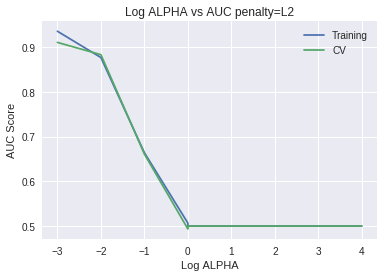

In [99]:
plt.plot(Alpha,AUC_score_training,label='Training')
plt.plot(Alpha,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**Obsrvation:** Optimal value of Alpha=0.01 with Penalty =L2 having AUC Score=0.92

 AUC =  0.9257603577577427


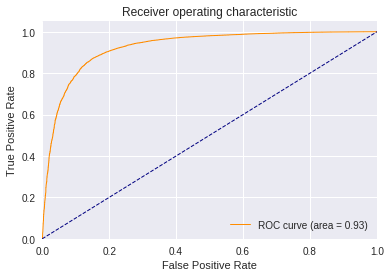

In [102]:

clf = SGDClassifier(alpha=0.01, penalty='l2') 
clf.fit(Train_bows,y_Train)
calibrator=CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
calibrator.fit(train_bows,y_train)
y_pred=calibrator.predict_proba(test_bows)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve( y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [103]:
#Confusion Matrix
y_pred=clf.predict(test_bows)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.33      0.48      5267
           1       0.87      0.99      0.93     24733

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.88      0.66      0.70     30000
weighted avg       0.88      0.88      0.85     30000



**Top Positive Features**

In [104]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Positive Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Positive Feature
0.34		 best
0.32		 delicious
0.27		 excellent
0.26		 perfect
0.26		 loves
0.25		 wonderful
0.24		 love
0.23		 good
0.22		 amazing
0.22		 tasty
0.21		 favorite
0.21		 nice
0.20		 pleased
0.19		 easy
0.18		 awesome
0.18		 loved
0.18		 highly
0.18		 yummy
0.17		 happy


**Top Negative Features**

In [105]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Negative Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Negative Feature
-0.38		 worst
-0.36		 awful
-0.34		 horrible
-0.34		 money
-0.32		 waste
-0.32		 terrible
-0.28		 threw
-0.28		 stale
-0.27		 return
-0.25		 bad
-0.25		 disappointing
-0.24		 unfortunately
-0.22		 maybe
-0.22		 away
-0.21		 disappointment
-0.21		 worse
-0.20		 bland
-0.19		 refund
-0.19		 nasty


**5.1.2 TFIDF**

In [0]:
from sklearn.calibration import CalibratedClassifierCV

**Simple Cross Validation penalty=l2**

In [108]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict_proba(train_tfidf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(train_tfidf,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  y_predict_cv=calibarator.predict_proba(cv_tfidf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10
  

Alpha=  0.0001   0.9641722040966041
Alpha=  0.0001   0.9485185023886873
Alpha=  0.001   0.9547059140995857
Alpha=  0.001   0.9444515208529195
Alpha=  0.01   0.954955888895324
Alpha=  0.01   0.9445598458390652
Alpha=  0.1   0.6011483790978376
Alpha=  0.1   0.6071457492871095
Alpha=  1.0   0.5995655669028359
Alpha=  1.0   0.6069990998222419
Alpha=  10.0   0.5995655669028359
Alpha=  10.0   0.6069990998222419
Alpha=  100.0   0.5995655669028359
Alpha=  100.0   0.6069990998222419
Alpha=  1000.0   0.5995655669028359
Alpha=  1000.0   0.6069990998222419
Alpha=  10000.0   0.5995655669028359
Alpha=  10000.0   0.6069990998222419


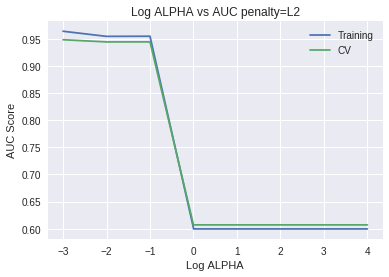

In [109]:
plt.plot(Alpha_training,AUC_score_training,label='Training')
plt.plot(Alpha_cv,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**Simple Cross Validation Penalty-L2**

In [110]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l1',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict_proba(train_tfidf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(train_tfidf,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  y_predict_cv=calibarator.predict_proba(cv_tfidf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10
  

Alpha=  0.0001   0.932785460036766
Alpha=  0.0001   0.9332213778033664
Alpha=  0.001   0.7606707551196827
Alpha=  0.001   0.7481873664266858
Alpha=  0.01   0.5
Alpha=  0.01   0.5
Alpha=  0.1   0.5
Alpha=  0.1   0.5
Alpha=  1.0   0.5
Alpha=  1.0   0.5
Alpha=  10.0   0.5
Alpha=  10.0   0.5
Alpha=  100.0   0.5
Alpha=  100.0   0.5
Alpha=  1000.0   0.5
Alpha=  1000.0   0.5
Alpha=  10000.0   0.5
Alpha=  10000.0   0.5


**Observation :** Optimal Value of ALPHA=10^-2

 AUC =  0.9417379473417834


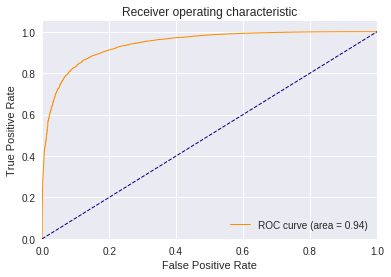

In [112]:
clf = SGDClassifier(loss='hinge',alpha=0.001, penalty='l2') 
clf.fit(Train_tfidf,y_Train)
calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
calibarator.fit(Train_tfidf,y_Train)
y_pred=calibarator.predict_proba(test_tfidf)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [113]:
#Confusion_Metrics
y_pred=clf.predict(test_tfidf)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5267
           1       0.82      1.00      0.90     24733

   micro avg       0.82      0.82      0.82     30000
   macro avg       0.41      0.50      0.45     30000
weighted avg       0.68      0.82      0.75     30000



**Top Positive Features**

In [114]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Positive Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Positive Feature
0.52		 best
0.41		 delicious
0.40		 good
0.37		 love
0.34		 perfect
0.32		 excellent
0.29		 wonderful
0.29		 loves
0.27		 nice
0.27		 amazing
0.25		 tasty
0.24		 find
0.24		 favorite
0.22		 easy
0.22		 highly
0.22		 pleased
0.20		 awesome
0.20		 smooth
0.20		 little


**Top Negative Features**

In [115]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Negative Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Negative Feature
-0.77		 waste
-0.76		 awful
-0.71		 horrible
-0.67		 terrible
-0.63		 threw
-0.63		 return
-0.61		 money
-0.59		 disappointed
-0.56		 stale
-0.52		 not
-0.48		 disappointing
-0.44		 refund
-0.41		 bad
-0.39		 disappointment
-0.38		 worse
-0.38		 disgusting
-0.37		 away
-0.33		 maybe
-0.33		 unfortunately


**5.1.3 Linear SVM on Avg Word2Vec**

In [116]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(sent_vectors,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict_proba(sent_vectors)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(sent_vectors,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(sent_vectors,y_train)
  y_predict_cv=calibarator.predict_proba(sent_vectors_cv)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10

Alpha=  0.0001   0.8885253966721794
Alpha=  0.0001   0.7277184828908292
Alpha=  0.001   0.8955995787134459
Alpha=  0.001   0.7533509107058025
Alpha=  0.01   0.8944477589657459
Alpha=  0.01   0.7680591040814051
Alpha=  0.1   0.893144389316825
Alpha=  0.1   0.7544612498047217
Alpha=  1.0   0.8922240111885472
Alpha=  1.0   0.7724603620128981
Alpha=  10.0   0.7453827070878675
Alpha=  10.0   0.7000118185788219
Alpha=  100.0   0.6250597321698618
Alpha=  100.0   0.6398522158237105
Alpha=  1000.0   0.625060840728371
Alpha=  1000.0   0.6398520080596475
Alpha=  10000.0   0.6250602160916878
Alpha=  10000.0   0.6398522158237105


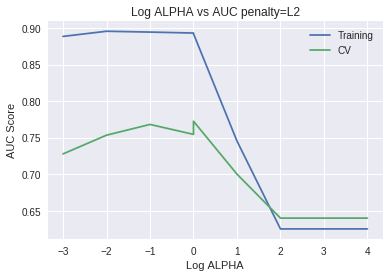

In [117]:
plt.plot(Alpha_training,AUC_score_training,label='Training')
plt.plot(Alpha_cv,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

 **Observation:** Optimal value of ALPHA=1

 AUC =  0.7896474810440091


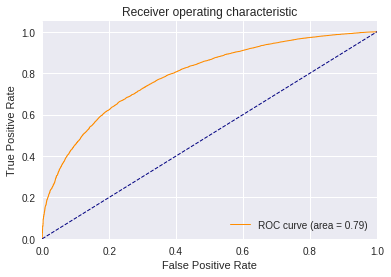

In [119]:
clf = SGDClassifier(loss='hinge',alpha=0.01, penalty='l2') 
clf.fit(sent_vectors,y_train)
calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
calibarator.fit(sent_vectors,y_train)
y_pred=calibarator.predict_proba(sent_vectors_test)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [120]:
#Confusion_Metrices
y_pred=clf.predict(sent_vectors_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.01      0.02      5267
           1       0.83      1.00      0.90     24733

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.76      0.51      0.46     30000
weighted avg       0.80      0.83      0.75     30000



**5.1.4 Linear SVM on TF-IDF Weighted Word2Vec**

In [121]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(tfidf_sent_vectors_train,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict_proba(tfidf_sent_vectors_train)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(tfidf_sent_vectors_train,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(tfidf_sent_vectors_train,y_train)
  y_predict_cv=calibarator.predict_proba(tfidf_sent_vectors_cv)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10

Alpha=  0.0001   0.862560550503978
Alpha=  0.0001   0.6718185468581879
Alpha=  0.001   0.8673441795315655
Alpha=  0.001   0.7616582369061693
Alpha=  0.01   0.86801871164394
Alpha=  0.01   0.7383961413418922
Alpha=  0.1   0.8683304190771595
Alpha=  0.1   0.7348510791145575
Alpha=  1.0   0.8689327850602007
Alpha=  1.0   0.7269792024177345
Alpha=  10.0   0.7557602836605597
Alpha=  10.0   0.6754391712770977
Alpha=  100.0   0.6192875332213621
Alpha=  100.0   0.6190173878543526
Alpha=  1000.0   0.6192871625578358
Alpha=  1000.0   0.6190173239269485
Alpha=  10000.0   0.6192867198208459
Alpha=  10000.0   0.6190177714187769


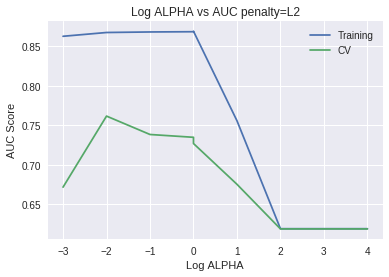

In [122]:
plt.plot(Alpha_training,AUC_score_training,label='Training')
plt.plot(Alpha_cv,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**OBSERVATION:-** Optimal value of ALPHA =0.01

 AUC =  0.7337065805464215


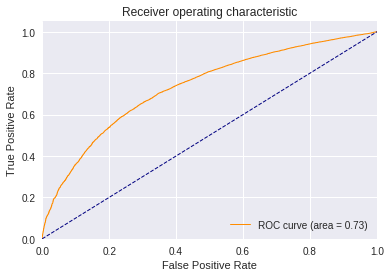

In [124]:
clf = SGDClassifier(loss='hinge',alpha=0.01, penalty='l2') 
clf.fit(tfidf_sent_vectors_train,y_train)
calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
calibarator.fit(tfidf_sent_vectors_train,y_train)
y_pred=calibarator.predict_proba(tfidf_sent_vectors_test)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [125]:
#Confusion_Metrices
y_pred=clf.predict(tfidf_sent_vectors_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5267
           1       0.82      1.00      0.90     24733

   micro avg       0.82      0.82      0.82     30000
   macro avg       0.41      0.50      0.45     30000
weighted avg       0.68      0.82      0.75     30000



# 5.2 RBF SVM

In [0]:
from sklearn.svm import SVC

**5.2.1 RBF SVM on BOWs**

**Simple Cross Validation**

In [127]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(train_bows_rbf,y_train_rbf)
  #For Train Curve
  y_predict_training=calibarator.predict_proba(train_bows_rbf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train_rbf,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(train_bows_rbf,y_train_rbf)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(train_bows_rbf,y_train_rbf)
  y_predict_cv=calibarator.predict_proba(cv_bows_rbf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv_rbf,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10

Train->C=  0.0001   0.71312931740846
CV->C=  0.0001   0.7262462936125496
Train->C=  0.001   0.8505284405124104
CV->C=  0.001   0.8464999056611017
Train->C=  0.01   0.9144570453247731
CV->C=  0.01   0.8838815426652213
Train->C=  0.1   0.9162769316564628
CV->C=  0.1   0.8848120029784426
Train->C=  1.0   0.9164401370996337
CV->C=  1.0   0.884916240390866
Train->C=  10.0   0.9312293394840043
CV->C=  10.0   0.8908747417800922
Train->C=  100.0   0.9617520232311343
CV->C=  100.0   0.892738894574362
Train->C=  1000.0   0.9900201945772542
CV->C=  1000.0   0.8712696238039463
Train->C=  10000.0   0.9952141702927431
CV->C=  10000.0   0.8325320923963656


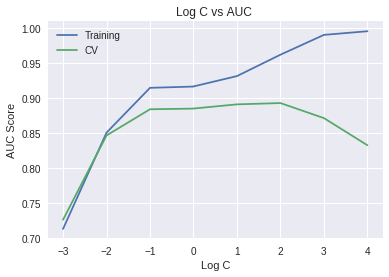

In [128]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal value of C=0.1 having auc=0.87

 AUC =  0.9096241206512959


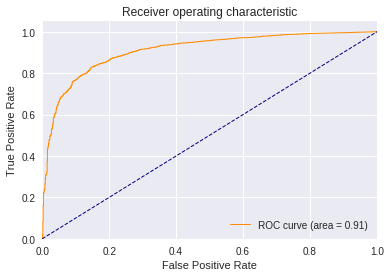

In [129]:
clf = SVC(C=0.1,kernel='rbf',gamma='auto')
clf.fit(Train_bows_rbf,y_Train_rbf)
calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
calibarator.fit(Train_bows_rbf,y_Train_rbf)
y_pred=calibarator.predict_proba(test_bows_rbf)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test_rbf,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [130]:
#Confusion_Matrices
y_pred=clf.predict(test_bows_rbf)
print(metrics.classification_report(y_test_rbf,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1084
           1       0.82      1.00      0.90      4916

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.41      0.50      0.45      6000
weighted avg       0.67      0.82      0.74      6000



**5.1.2 RBF SVM on TFIDF**

In [131]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(train_tfidf_rbf,y_train_rbf)
  
  #For Train Curve
  y_predict_training=calibarator.predict_proba(train_tfidf_rbf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train_rbf,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(train_tfidf_rbf,y_train_rbf)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(train_tfidf_rbf,y_train_rbf)
  y_predict_cv=calibarator.predict_proba(cv_tfidf_rbf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv_rbf,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10
  

Train->C=  0.0001   0.9145448708607142
CV->C=  0.0001   0.8847150379436303
Train->C=  0.001   0.9153015827397313
CV->C=  0.001   0.8847150379436303
Train->C=  0.01   0.9213074371281703
CV->C=  0.01   0.8847150379436303
Train->C=  0.1   0.9202898083805686
CV->C=  0.1   0.8847150379436303
Train->C=  1.0   0.9368840682624198
CV->C=  1.0   0.9083579415777585
Train->C=  10.0   0.9798559996624674
CV->C=  10.0   0.9261134515148566
Train->C=  100.0   0.981399345889531
CV->C=  100.0   0.9278725588547461
Train->C=  1000.0   0.9813579487273639
CV->C=  1000.0   0.9278430653233238
Train->C=  10000.0   0.9894460185860019
CV->C=  10000.0   0.9289654356012782


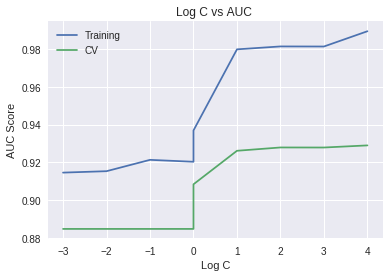

In [132]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal Value of C=100

 AUC =  0.9329234835269427


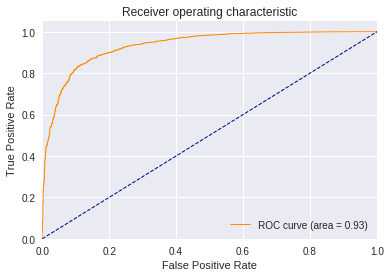

In [133]:
clf = SVC(C=100,kernel='rbf',gamma='auto')
clf.fit(Train_tfidf_rbf,y_Train_rbf)
calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
calibarator.fit(Train_tfidf_rbf,y_Train_rbf)
y_pred=calibarator.predict_proba(test_tfidf_rbf)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test_rbf,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [134]:
#Confusion_Metrices
y_pred=clf.predict(test_tfidf_rbf)
print(metrics.classification_report(y_test_rbf,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1084
           1       0.82      1.00      0.90      4916

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.41      0.50      0.45      6000
weighted avg       0.67      0.82      0.74      6000



**5.2.3 RBF SVM on Avg Word2Vec**

In [135]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(sent_vectors_rbf,y_train_rbf)
  
 
  #For Train Curve
  y_predict_training=calibarator.predict_proba(sent_vectors_rbf)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train_rbf,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(sent_vectors_rbf,y_train_rbf)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(sent_vectors_rbf,y_train_rbf)
  y_predict_cv=calibarator.predict_proba(sent_vectors_rbf_cv)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv_rbf,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10
  

Train->C=  0.0001   0.7462280697650752
CV->C=  0.0001   0.5384133045724266
Train->C=  0.001   0.7933686689152946
CV->C=  0.001   0.4586688559216749
Train->C=  0.01   0.8055242526907493
CV->C=  0.01   0.4929981144340939
Train->C=  0.1   0.8310560627909331
CV->C=  0.1   0.411627077324363
Train->C=  1.0   0.8658114960360672
CV->C=  1.0   0.4088235757553475
Train->C=  10.0   0.873475178782339
CV->C=  10.0   0.40952334008991087
Train->C=  100.0   0.8740447648963363
CV->C=  100.0   0.4101996712077277
Train->C=  1000.0   0.8768357633349837
CV->C=  1000.0   0.4113935531988563
Train->C=  10000.0   0.8913008497716403
CV->C=  10000.0   0.41985456052820086


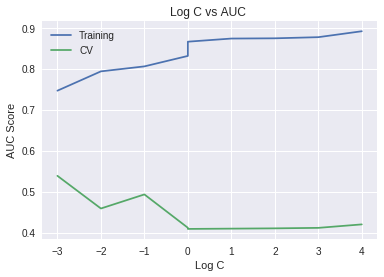

In [136]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

**Optimal value of c= 0.0001**

 AUC =  0.6069802947826062


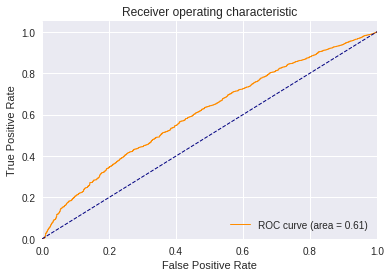

In [144]:
clf = SVC(C=0.0001,kernel='rbf',gamma='auto')
clf.fit(sent_vectors_rbf,y_train_rbf)
calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
calibarator.fit(sent_vectors_rbf,y_train_rbf)
y_pred=calibarator.predict_proba(sent_vectors_rbf_test)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test_rbf,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [145]:
#Confusion_Metrices
y_pred=clf.predict(sent_vectors_rbf_test)
print(metrics.classification_report(y_test_rbf,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1084
           1       0.82      1.00      0.90      4916

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.41      0.50      0.45      6000
weighted avg       0.67      0.82      0.74      6000



**5.2.4  RBF SVM on TFIDF-W2Vec**

In [140]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(tfidf_sent_vectors_rbf_train,y_train_rbf)
  #For Train Curve
  y_predict_training=calibarator.predict_proba(tfidf_sent_vectors_rbf_train)[:,1]
  fpr,tpr,thresholds=roc_curve(y_train_rbf,y_predict_training)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(tfidf_sent_vectors_rbf_train,y_train_rbf)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(tfidf_sent_vectors_rbf_train,y_train_rbf)
  y_predict_cv=calibarator.predict_proba(tfidf_sent_vectors_rbf_cv)[:,1]
  fpr,tpr,thresholds=roc_curve(y_cv_rbf,y_predict_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10
  

Train->C=  0.0001   0.7039654509346976
CV->C=  0.0001   0.5880202123615067
Train->C=  0.001   0.7437588040686438
CV->C=  0.001   0.5988532268549512
Train->C=  0.01   0.7821574523850987
CV->C=  0.01   0.5529136174866743
Train->C=  0.1   0.7971811798438365
CV->C=  0.1   0.5254272622851668
Train->C=  1.0   0.8527555019167593
CV->C=  1.0   0.5339048344746253
Train->C=  10.0   0.859249913432267
CV->C=  10.0   0.5379446402374997
Train->C=  100.0   0.8605460241556413
CV->C=  100.0   0.5381135210064647
Train->C=  1000.0   0.867331981143725
CV->C=  1000.0   0.5445152334089796
Train->C=  10000.0   0.8926517742214664
CV->C=  10000.0   0.48549382878156566


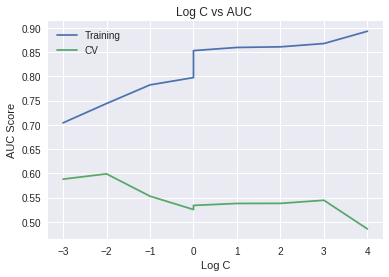

In [141]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal Value of C=0.01

 AUC =  0.5738173454252851


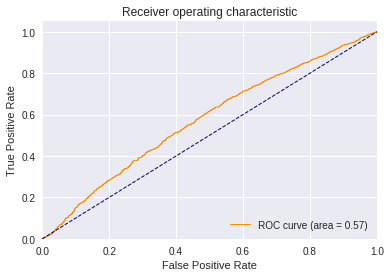

In [142]:
clf = SVC(C=0.01,kernel='rbf',gamma='auto')
clf.fit(tfidf_sent_vectors_rbf_train,y_train_rbf)
calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
calibarator.fit(tfidf_sent_vectors_rbf_train,y_train_rbf)
y_pred=calibarator.predict_proba(tfidf_sent_vectors_rbf_test)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test_rbf,y_pred)
roc_auc = metrics.auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [143]:
#Confusion_Metrices
y_pred=clf.predict(tfidf_sent_vectors_rbf_test)
print(metrics.classification_report(y_test_rbf,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1084
           1       0.82      1.00      0.90      4916

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.41      0.50      0.45      6000
weighted avg       0.67      0.82      0.74      6000

